### Test hirarchical clustering and consensus functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from clustertools.load_data import load_fuzzy_data
from scipy.spatial import distance
from copy import deepcopy
from timeit import default_timer as timer
from datetime import timedelta
import importlib
%matplotlib inline

In [3]:
from clustertools.models import consensus
from clustertools.models import similarity
from clustertools.models import density
from clustertools.models import distance as cl_dist

In [4]:
fuzzy = load_fuzzy_data()
len(fuzzy)

2309

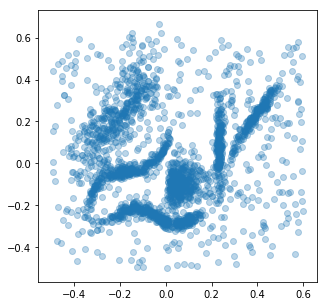

In [5]:
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[:,0], fuzzy[:,1],alpha=.3)

In [6]:
fuzzy_copy = deepcopy(fuzzy)
np.random.shuffle(fuzzy)

Set some parameters

In [7]:
k = 10 # number of clusters to go down to
stop_dist = 0.3
num_stop_crit = 1
stride = 2
data = fuzzy[::stride]
n = len(data) # number of data points
print(n)
link = 'average'
#link = 'complete'
#link = 'single'
metric='euclidean'

1155


Fit hierarchical clustering object and plot results

Hierarchical clustering terminated.
Finished after 0:00:06.168407
Stopping cluster number was reached.
Current number of clusters: 10
Stopping distance was reached.
Current minimum cluster distance: 0.32


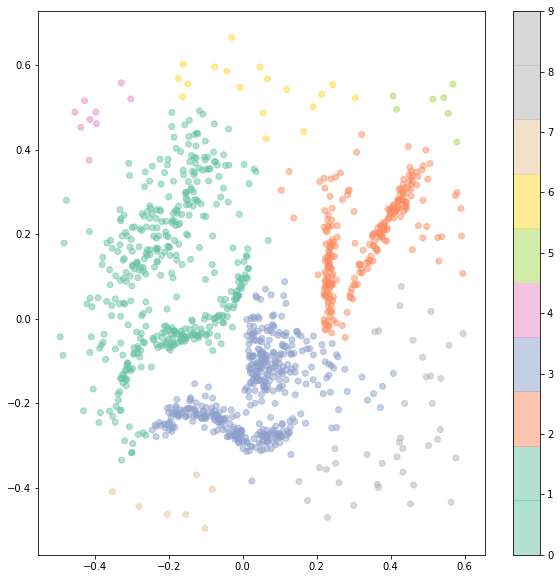

In [8]:
hiercl_obj = similarity.HierarchicalClustering(data, link=link, num_stop_crit=num_stop_crit, metric=metric, k=k, stop_dist=stop_dist)
hiercl_obj.fit()
labels = hiercl_obj.cluster_labels
plt.figure(figsize=(10, 10))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

Fit some other clustering methods

Detected 6 clusters
Finished after 0:00:00.094887
Rate of noise in dataset: 0.279654


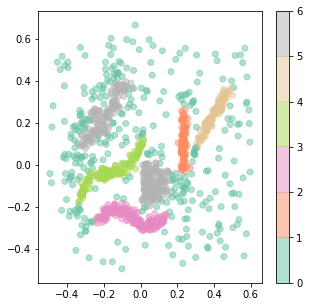

In [9]:
dbscan_obj = density.DBSCAN(data, eps=0.03, minPts=10)
dbscan_obj.fit()
labels = dbscan_obj.cluster_labels
for i in range(len(labels)):
    if labels[i] == 'noise':
        labels[i] = 0
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', dbscan_obj._n_clusters), alpha=.5)
plt.colorbar()

terminated by break condition
26 iterations until termination.
Finished after 0:00:00.022013
max within-cluster distance to center: 0.339698
mean within-cluster distance to center: 0.085179
sum of within cluster squared errors: 11.849298


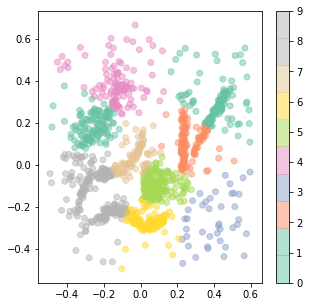

In [10]:
kmeans_obj = cl_dist.KMeans(data, 10)
kmeans_obj.fit()
labels = kmeans_obj.cluster_labels
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

Constructing gaussian similarity matrix
Computing generalized Laplacian eigenproblem


KMeans initialization on eigenvectors...
terminated by break condition
4 iterations until termination.
Finished after 0:00:00.033769
max within-cluster distance to center: 0.422755
mean within-cluster distance to center: 0.053116
sum of within cluster squared errors: 5.368963
KMeans terminated. 

Finished after 0:00:12.861185


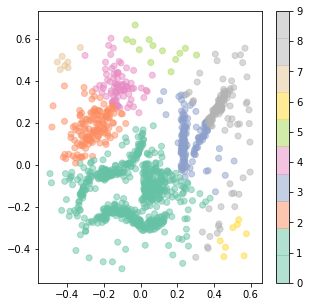

In [11]:
spectral_obj = similarity.SpectralClustering(data, n=10, bandwidth=0.1)
spectral_obj.fit()
labels = spectral_obj.cluster_labels
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

Set some parameters

In [12]:
stride = 2
data = fuzzy[::stride]
n = len(data)

#clusterings = [kmeans_obj, kmeans_obj]
#clusterings = [hiercl_obj, hiercl_obj]
#clusterings = [kmeans_obj, dbscan_obj]
clusterings = [spectral_obj, dbscan_obj, kmeans_obj, hiercl_obj]
recluster_what = 'clusters'
#recluster_what = 'points'
#how = 'hierarchical'
how = 'spectral'
k = 8 # how many clusters to produce

Computing generalized Laplacian eigenproblem


KMeans initialization on eigenvectors...
terminated by break condition
2 iterations until termination.
Finished after 0:00:00.014301
max within-cluster distance to center: 16.497051
mean within-cluster distance to center: 6.273972
sum of within cluster squared errors: 2079.044882
KMeans terminated. 

Finished after 0:00:00.016850
Consensus clustering terminated.
Finished after 0:00:00.047936


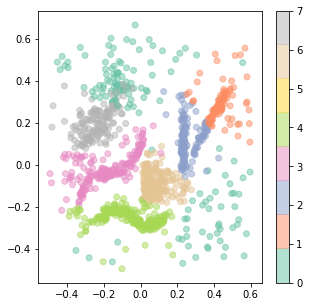

In [13]:
consensus_obj = consensus.Consensus(clusterings=clusterings, k=k, recluster_what=recluster_what, how=how)
consensus_obj.fit()
labels = consensus_obj.cluster_labels
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

### Vielleicht kann ich mit -einem- consensus die jeweils Algorithmen-typischen Probleme beheben? (Jeweils einen passenden toy-Datensatz heraussuchen...) Das wäre doch cool für die Präsentation!

In [14]:
from clustertools.load_data import load_spiral_data, load_aggregation_data, load_birch1_data, load_birch3_data, load_compound_data, load_flame_data, load_pathbased_data, load_sets_data, scale_data, load_fuzzy_data

In [15]:
spiral=load_spiral_data(scale = 'True')
aggr=load_aggregation_data(scale = 'True')
compound = load_compound_data(scale = 'True')
fuzzy = load_fuzzy_data(scale = 'True')
fuzzy = fuzzy[np.arange(0,2309,2),:]
pathbased = load_pathbased_data(scale = 'True')
dataset = [spiral, aggr, compound, fuzzy, pathbased]

312

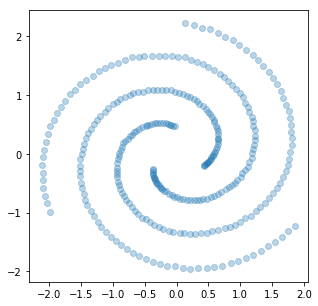

In [18]:
plt.figure(figsize=(5, 5))
plt.scatter(spiral[:,0], spiral[:,1],alpha=.3)
len(spiral)

Computing generalized Laplacian eigenproblem


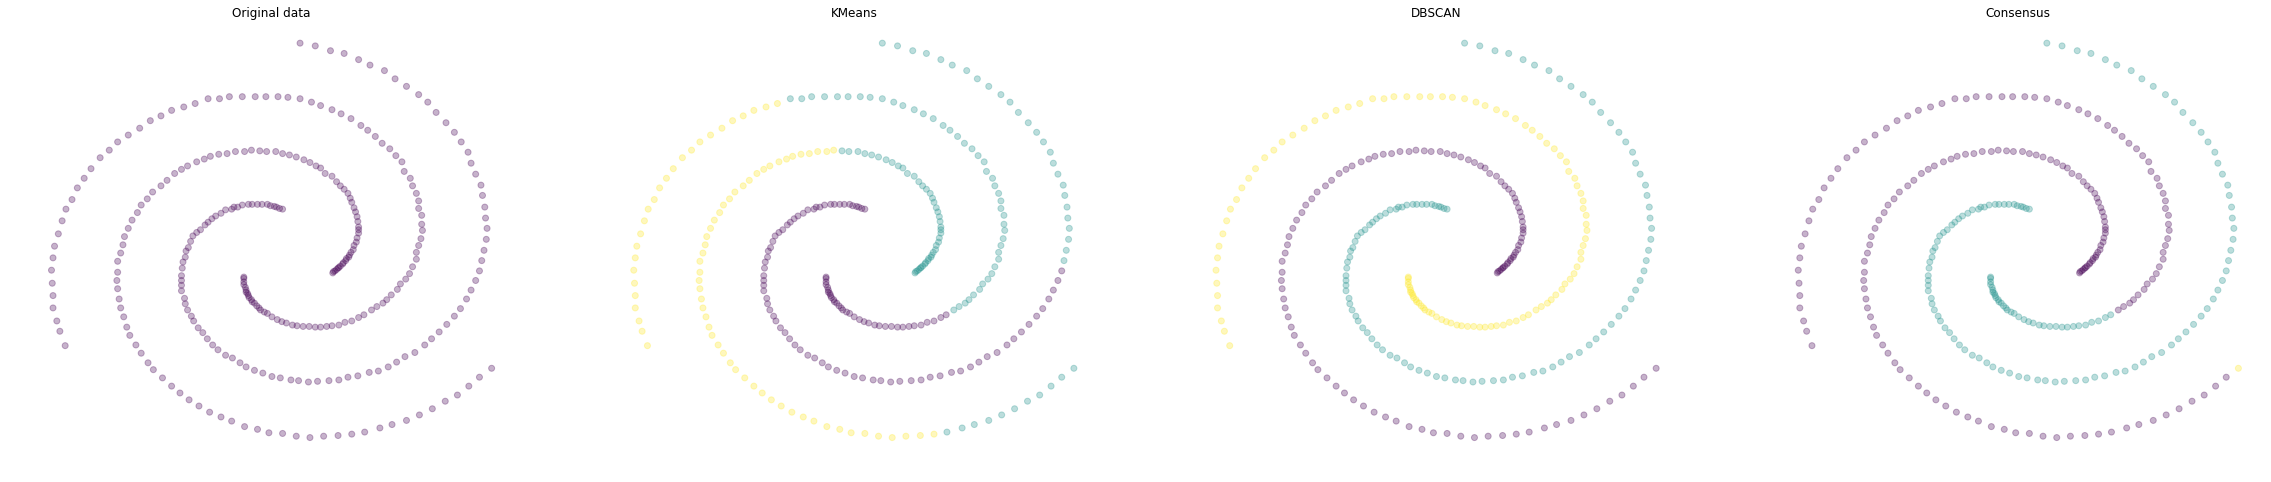

In [61]:
# Init
data = spiral
no_labels = [0] * len(data)

# Fit DBSCAN and KMeans
dbscan_obj = density.DBSCAN(data, eps=0.6, minPts=5, verbose=False)
dbscan_labels = dbscan_obj.cluster_labels
for i in range(len(dbscan_labels)):
    if dbscan_labels[i] == 'noise':
        dbscan_labels[i] = 0
dbscan_obj2 = density.DBSCAN(data, eps=1, minPts=10, verbose=False)
dbscan_labels2 = dbscan_obj2.cluster_labels
for i in range(len(dbscan_labels2)):
    if dbscan_labels2[i] == 'noise':
        dbscan_labels2[i] = 0
k = 3
num_clusterings = 10
kmeans_objects = []
dbscan_objects = [dbscan_obj]*num_clusterings
for i in range(num_clusterings):
    kmeans_obj = cl_dist.KMeans(data, k=i+3, verbose=False)
    kmeans_labels = kmeans_obj.cluster_labels
    kmeans_objects.append(kmeans_obj)
    
kmeans_obj = cl_dist.KMeans(data, k, verbose=False)
kmeans_labels = kmeans_obj.cluster_labels
kmeans_obj2 = cl_dist.KMeans(data, k, verbose=False)
kmeans_labels2 = kmeans_obj2.cluster_labels

# Fit consensus
#clusterings = [*kmeans_objects, *dbscan_objects]
#clusterings = [*kmeans_objects]
clusterings = [kmeans_obj, dbscan_obj]
recluster_what = 'points'
how = 'spectral'
consensus_obj = consensus.Consensus(clusterings=clusterings, k=k, recluster_what=recluster_what, how=how, verbose=False)
consensus_labels = consensus_obj.cluster_labels

# Plot results
#labels = [no_labels, kmeans_labels, kmeans_labels2, dbscan_labels, dbscan_labels2, consensus_labels]
labels = [no_labels, kmeans_labels, dbscan_labels, consensus_labels]
num_plots = 4
f, axarr = plt.subplots(1,num_plots, figsize=(40,8))

for i in range(num_plots):
    axarr[i].scatter(data[:, 0], data[:, 1], alpha=.3, c=labels[i])
    axarr[i].axis('off')
    
axarr[0].set_title('Original data')
axarr[1].set_title('KMeans')
axarr[2].set_title('DBSCAN')
axarr[3].set_title('Consensus')
#axarr[4].set_title('DBSCAN2')
#axarr[5].set_title('Consensus')
plt.show()

### Take a bigger variety! For that, make a list with different parameters - for DBSCAN, zip them together. For KMeans, just take a different number of clusters every time. Then, plot all DBSCANs and KMeans' in a row, and consensus (big?) in the last row